In [1]:
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import os
from PIL import Image
from src.tools.train_utils import define_model
import torch
import pickle
import pandas as pd
from torch_geometric.data import Batch
import numpy as np

def plot_patch(fname, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = Image.open(os.path.join('../data/path/patch', fname))
    ax.imshow(img)
    ax.axis('off')

def plot_roi(fname, ax=None):
    if ax is None:
        fig, ax = plt.figure()
    img = Image.open(os.path.join('../data/path/ROIs', f'{fname}.png'))
    ax.imshow(img)
    ax.axis('off')

@torch.no_grad()
def compute_graph_attention_scores(model_fpath):
    scores = {}
    task = 'surv' if 'surv' in model_fpath else 'grad'
    for k in range(1, 16):
        fpath = f'{model_fpath[:-4]}{k}.pt'
        ckpt = torch.load(fpath, map_location=torch.device('cpu'))
        opt = ckpt['opt']
        opt.qbt = 0
        # Update legacy checkpoint
        opt.pool = 'attn'
        opt.device = 'cpu'
        opt.save_dir = '../checkpoints'
        model = define_model(opt)
        model.load_state_dict(ckpt['model'])
        model.to('cpu')
        model.eval()
        scores[k] = {}

        graph_dir = '../data/graphs'
        for graph_fname in os.listdir(graph_dir):
            roi = graph_fname[:-3]
            graph = torch.load(f'{graph_dir}/{graph_fname}')
            graph = Batch.from_data_list([graph])
            graph.to('cpu')
            if 'omic' in model_fpath:
                A = model.graph_net.get_attn_score(graph)
            else:
                A = model.get_attn_score(graph)
            scores[k][roi] = A.squeeze().detach().numpy()

    df = pd.DataFrame.from_dict(scores[1], orient='index', columns=['1'])
    dfs = [pd.DataFrame.from_dict(scores[k], orient='index', columns=[str(k)]) for k in range(2, 3)]
    df = pd.concat([df] + dfs, axis=1)

    # compute average attention score
    df['A'] = df.mean(axis=1)

    # noramlize
    # df = (df - df.min()) / (df.max() - df.min())

    df = df.drop(columns=[str(k) for k in range(1, 3)])

    df = df.sort_values(by='A', ascending=False)
    return df

@torch.no_grad()
def compute_patch_attention_scores(model_fpath):
    scores = {}
    task = 'surv' if 'surv' in model_fpath else 'grad'
    for k in range(1, 16):
        fpath = f'{model_fpath[:-4]}{k}.pt'
        ckpt = torch.load(fpath, map_location=torch.device('cpu'))
        opt = ckpt['opt']
        # Update legacy checkpoint
        opt.qbt = 0
        opt.device = 'cpu'
        opt.pool = 'attn'
        opt.save_dir = '../checkpoints'
        model = define_model(opt)
        model.load_state_dict(ckpt['model'])
        model.to('cpu')
        model.eval()

        vgg_feats = f'../data/path/vgg_features_{task}.pkl'
        with open(vgg_feats, 'rb') as f:
            vgg_dict = pickle.load(f)

        scores[k] = {}

        for pat, path in vgg_dict[str(k)].items():
            path = torch.FloatTensor(path).unsqueeze(0)
            x = model.aggregate.nn(path)
            A = model.aggregate.attn(x)
            scores[k][pat] = A.squeeze().detach().numpy()


    df = pd.DataFrame.from_dict(scores[1], orient='index', columns=['1'])
    dfs = [pd.DataFrame.from_dict(scores[k], orient='index', columns=[str(k)]) for k in range(2, 16)]
    df = pd.concat([df] + dfs, axis=1)

    # compute average attention score
    df['A'] = df.mean(axis=1)

    # noramlize
    # df = (df - df.min()) / (df.max() - df.min())

    df = df.drop(columns=[str(k) for k in range(1, 16)])

    df = df.sort_values(by='A', ascending=False)
    return df


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
surv_patch = compute_patch_attention_scores('../checkpoints/surv/pathgraphomic_rna_global_attn/pathgraphomic_1.pt')
surv_graph = compute_graph_attention_scores('../checkpoints/surv/pathgraphomic_rna_global_attn/pathgraphomic_1.pt')
grad_patch = compute_patch_attention_scores('../checkpoints/grad/pathgraphomic_global_attn/pathgraphomic_1.pt')
grad_graph = compute_graph_attention_scores('../checkpoints/grad/pathgraphomic_global_attn/pathgraphomic_1.pt')

Loading ../checkpoints/surv/omic_rna/omic_1.pt
Loading ../checkpoints/surv/graph_global_attn/graph_1.pt
Loading ../checkpoints/surv/omic_rna/omic_2.pt
Loading ../checkpoints/surv/graph_global_attn/graph_2.pt
Loading ../checkpoints/surv/omic_rna/omic_3.pt
Loading ../checkpoints/surv/graph_global_attn/graph_3.pt
Loading ../checkpoints/surv/omic_rna/omic_4.pt
Loading ../checkpoints/surv/graph_global_attn/graph_4.pt
Loading ../checkpoints/surv/omic_rna/omic_5.pt
Loading ../checkpoints/surv/graph_global_attn/graph_5.pt
Loading ../checkpoints/surv/omic_rna/omic_6.pt
Loading ../checkpoints/surv/graph_global_attn/graph_6.pt
Loading ../checkpoints/surv/omic_rna/omic_7.pt
Loading ../checkpoints/surv/graph_global_attn/graph_7.pt
Loading ../checkpoints/surv/omic_rna/omic_8.pt
Loading ../checkpoints/surv/graph_global_attn/graph_8.pt
Loading ../checkpoints/surv/omic_rna/omic_9.pt
Loading ../checkpoints/surv/graph_global_attn/graph_9.pt
Loading ../checkpoints/surv/omic_rna/omic_10.pt
Loading ../check

In [38]:
surv_patch_worst = surv_patch.index[-3:]
surv_graph_worst = surv_graph.index[-4::2]
grad_patch_worst = grad_patch.index[-6::2]
grad_graph_worst = grad_graph.index[-4::2]

surv_patch_best = surv_patch.index[:6:2]
surv_graph_best = surv_graph.index[:4:2]
grad_patch_best = grad_patch.index[:6:2]
grad_graph_best = grad_graph.index[:4:2]

0 0
0 1
1 0
1 1


/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_56480/673556866.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


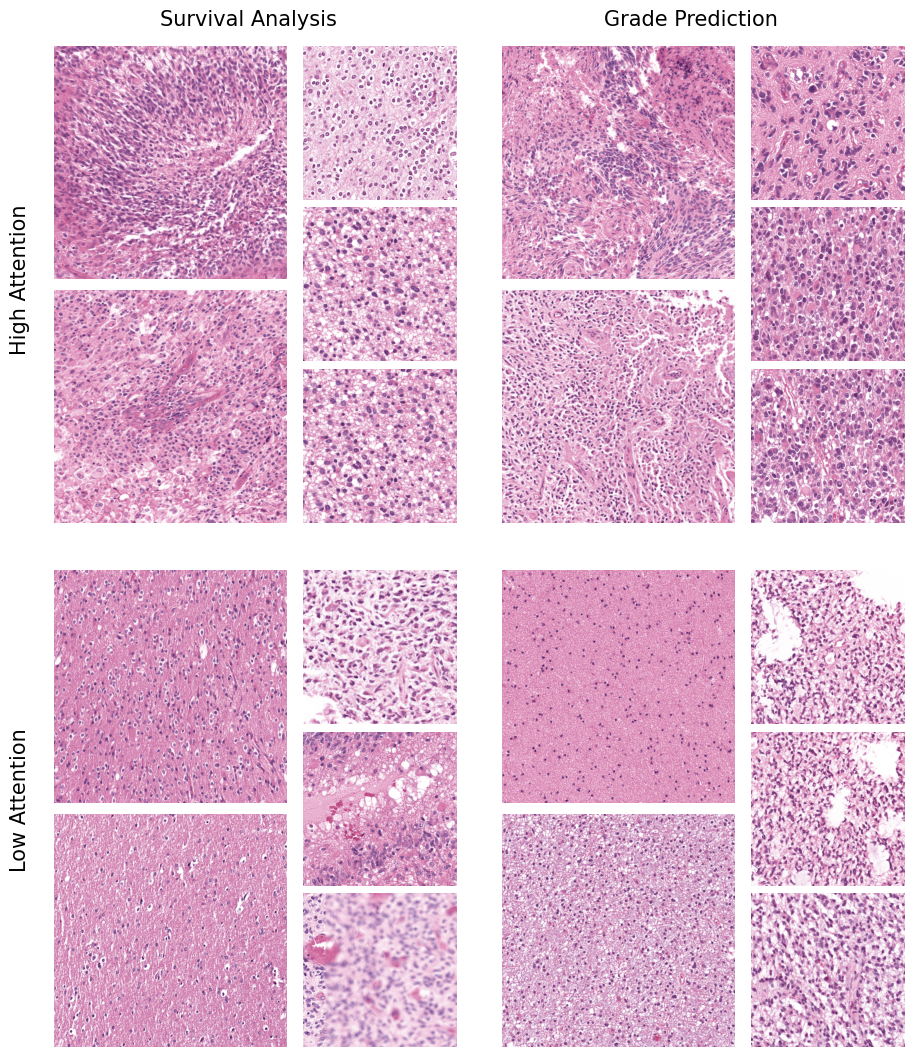

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create a figure
fig = plt.figure(figsize=(13, 13))

# Create a 2x2 main GridSpec
main_gs = gridspec.GridSpec(2, 2, hspace=0.1, wspace=-0.2)

for i, pats in enumerate(zip([surv_patch_best, grad_patch_best, surv_patch_worst, grad_patch_worst], [surv_graph_best, grad_graph_best, surv_graph_worst, grad_graph_worst])):
    patch, graph = pats
    row = i // 2
    col = i % 2

    print(row, col)
    
    # Create a GridSpec within the main grid
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=main_gs[row, col], width_ratios=[1, 1], height_ratios=[1, 1], wspace=-0.4, hspace=0.05)

    # First column, first large image
    ax1 = fig.add_subplot(gs[0, 0])
    plot_roi(graph[0], ax=ax1)
    ax1.axis('off')

    # First column, second large image
    ax2 = fig.add_subplot(gs[1, 0])
    plot_roi(graph[1], ax=ax2)
    ax2.axis('off')

    inner_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[:, 1], wspace=0.05, hspace=0.05)

    # Second column, first small image
    ax3 = fig.add_subplot(inner_gs[0])
    plot_patch(patch[0], ax=ax3)
    ax3.axis('off')

    # Second column, second small image
    ax4 = fig.add_subplot(inner_gs[1])
    plot_patch(patch[1], ax=ax4)
    ax4.axis('off')

    # Second column, third small image
    ax5 = fig.add_subplot(inner_gs[2])
    plot_patch(patch[2], ax=ax5)
    ax5.axis('off')

fig.text(0.144, 0.7, 'High Attention', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.144, 0.3, 'Low Attention', va='center', ha='center', rotation='vertical', fontsize=15)
fig.text(0.32, 0.9, 'Survival Analysis', va='center', ha='center', fontsize=15)
fig.text(0.66, 0.9, 'Grade Prediction', va='center', ha='center', fontsize=15)

plt.tight_layout()
plt.savefig('../report/figures/attention.png', dpi=300)
plt.show()